<a href="https://colab.research.google.com/github/Pavani-Jyothirmai/Stock-Prediction-Project/blob/main/CAPX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Movement Analysis Based on Social Media Sentiment**

In [2]:
pip install praw pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.7 MB/s eta 0:00:00


# **Data Scrapping**

In [3]:
import praw
import pandas as pd
import requests
from textblob import TextBlob

# Step 1: Reddit API credentials
CLIENT_ID = 'aRUMjsRkJ-mqKAtdvyJqYw'
CLIENT_SECRET = 'Ue2IVDlmbAIn_ZZeitMMigBxIJKMgA'
USER_AGENT = 'StockScraper by /u/Fuzzy_Tie6180'

# Step 2: Authenticate with Reddit API
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Step 3: Subreddits and keywords
subreddits = ["StockMarket", "WallStreetBets", "Investing", "personalfinance", "financialindependence"]
keywords = ["AAPL", "TSLA", "GOOG", "AMZN", "MSFT", "stock market", "investing", "cryptostocks", "dividends", "options", "tech stocks", "EV stocks", "short squeeze"]

# Step 4: Fetch posts from Reddit API
def fetch_reddit_data(subreddits, keywords, post_limit=1000):
    posts = []
    for subreddit in subreddits:
        for sort_option in ["hot", "top", "new"]:  # Fetch posts from hot, top, and new categories
            submissions = getattr(reddit.subreddit(subreddit), sort_option)(limit=post_limit)
            for submission in submissions:
                if any(keyword.lower() in submission.title.lower() for keyword in keywords):
                    sentiment = TextBlob(submission.title).sentiment
                    posts.append({
                        'Subreddit': subreddit,
                        'Sort': sort_option,  # Indicate which sort type was used
                        'Title': submission.title,
                        'Author': submission.author.name if submission.author else None,
                        'Score': submission.score,
                        'Upvote Ratio': submission.upvote_ratio,
                        'Comments': submission.num_comments,
                        'Created At': submission.created_utc,
                        'Post URL': submission.url,
                        'Sentiment Polarity': sentiment.polarity,
                        'Sentiment Subjectivity': sentiment.subjectivity
                    })
    return posts

# Step 5: Fetch historical data using Pushshift API
def fetch_pushshift_data(subreddit, keywords, start_time, end_time, limit=1000):
    base_url = "https://api.pushshift.io/reddit/search/submission/"
    posts = []
    for keyword in keywords:
        params = {
            "subreddit": subreddit,
            "q": keyword,
            "after": start_time,
            "before": end_time,
            "size": limit
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json().get("data", [])
            for post in data:
                posts.append({
                    'Subreddit': subreddit,
                    'Title': post.get('title', ''),
                    'Author': post.get('author', ''),
                    'Score': post.get('score', 0),
                    'Comments': post.get('num_comments', 0),
                    'Created At': post.get('created_utc', 0),
                    'Post URL': post.get('full_link', ''),
                })
    return posts

# Step 6: Fetch data and save to CSV
def main():
    print("Fetching data from Reddit API and Pushshift...")

    # Fetch posts from Reddit API
    reddit_data = fetch_reddit_data(subreddits, keywords, post_limit=500)

    # Fetch historical data from Pushshift
    start_time = "1672531200"  # Unix timestamp for January 1, 2023
    end_time = "1704067200"    # Unix timestamp for January 1, 2024
    pushshift_data = []
    for subreddit in subreddits:
        pushshift_data.extend(fetch_pushshift_data(subreddit, keywords, start_time, end_time, limit=500))

    # Combine both datasets
    all_posts = reddit_data + pushshift_data

    if all_posts:
        df = pd.DataFrame(all_posts)
        df['Created At'] = pd.to_datetime(df['Created At'], unit='s')  # Convert timestamps to datetime
        df.to_csv("reddit.csv", index=False)
        print("Data saved to 'reddit.csv'.")
    else:
        print("No relevant posts found.")

# Run the script
if __name__ == "__main__":
    main()


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetching data from Reddit API and Pushshift...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Data saved to 'reddit.csv'.


# **Data Pre-Processing**

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# 1. Load the Reddit data
df = pd.read_csv("/content/reddit.csv")

# 2. Handle Missing Data using Imputation
df['Score'] = df['Score'].fillna(df['Score'].mean())  # Fill missing Score with mean
df['Comments'] = df['Comments'].fillna(df['Comments'].mean())  # Fill missing Comments with mean

# For Upvote Ratio, use forward fill
df['Upvote Ratio'] = df['Upvote Ratio'].ffill()  # Forward fill for Upvote Ratio

# Handle missing sentiment values by filling them with the median
df['Sentiment Polarity'] = df['Sentiment Polarity'].fillna(df['Sentiment Polarity'].median())
df['Sentiment Subjectivity'] = df['Sentiment Subjectivity'].fillna(df['Sentiment Subjectivity'].median())

# 3. Replace Sentiment Polarity and Sentiment Subjectivity values of 0 with the mean
mean_sentiment_polarity = df['Sentiment Polarity'].mean()
mean_sentiment_subjectivity = df['Sentiment Subjectivity'].mean()

df['Sentiment Polarity'] = df['Sentiment Polarity'].replace(0, mean_sentiment_polarity)
df['Sentiment Subjectivity'] = df['Sentiment Subjectivity'].replace(0, mean_sentiment_subjectivity)

# 4. Clean text function to remove URLs, special characters, and make text lowercase
def clean_text(text):
    if isinstance(text, str):  # Check if the input is a string
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
        text = text.lower()  # Convert to lowercase
    return text

df['Cleaned Title'] = df['Title'].apply(clean_text)

# 5. Tokenization and optional short word removal
def preprocess_text(text):
    if isinstance(text, str):  # Ensure the text is a string
        # Tokenize the text into words (split by spaces)
        words = text.split()

        # Remove short words
        words = [word for word in words if len(word) > 2]

        return ' '.join(words)
    else:
        return ''

df['Processed Title'] = df['Cleaned Title'].apply(preprocess_text)

# 6. Vectorization: Convert text into numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features to avoid overfitting
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 7. Combine numerical features: Combine TF-IDF features with sentiment scores
X_combined = np.hstack([X_text, df[['Sentiment Polarity', 'Sentiment Subjectivity']].values])

# 8. Feature Scaling: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Final preprocessed data ready for model input
print("Preprocessing completed. Data ready for model input.")

# Save the cleaned dataframe if you want to examine it
df.to_csv("cleaned_reddit_data.csv", index=False)


Preprocessing completed. Data ready for model input.


In [24]:
print(df.head())

     Subreddit Sort                                              Title  \
0  StockMarket  hot  As an european do you buy only from EU stock m...   
1  StockMarket  hot  I know it’s not much, but I took my first step...   
2  StockMarket  hot                    Investing in AI infrastructure?   
3  StockMarket  hot  Starting My Investing Journey as an 18-Year-Ol...   
4  StockMarket  hot  BofA raises 2025 year-end S&P 500 target to 66...   

                Author  Score  Upvote Ratio  Comments           Created At  \
0        Christs_Elite      0          0.46        13  2024-12-07 01:42:18   
1  General_Thought8412    600          0.95        65  2024-12-04 18:07:27   
2      Typical-Ad-4591     15          0.79        25  2024-11-28 20:07:41   
3    Jayso_Productions      0          0.45        11  2024-11-27 21:03:44   
4        z34conversion     18          0.83        12  2024-11-26 21:56:01   

                                            Post URL  Sentiment Polarity  \
0  https:/

### **Data Analysis(Sentiment Analysis)**




In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer
import random

# Load the cleaned Reddit data
df = pd.read_csv("cleaned_reddit_data.csv")

# Initialize the VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get VADER Sentiment (compound score)
def get_vader_sentiment(text):
    if isinstance(text, str):
        sentiment_score = sia.polarity_scores(text)  # Get VADER sentiment scores
        return sentiment_score['compound']  # Return the compound score
    return 0  # Default to 0 if the text is not a string

# Apply the VADER sentiment analysis to the "Processed Title" column
df['VADER Sentiment'] = df['Processed Title'].apply(get_vader_sentiment)

# 1. Calculate the mean or median of the VADER Sentiment column
mean_sentiment_polarity = df['VADER Sentiment'].mean()  # Calculate the mean
median_sentiment_polarity = df['VADER Sentiment'].median()  # Calculate the median

# 2. Randomly replace a portion of `0` values with the mean or median
def replace_zeros_with_random_mean_or_median(sentiment_value, mean_value, median_value, replace_probability=0.5):
    if sentiment_value == 0:  # If the sentiment value is 0
        # Randomly decide whether to replace with mean or median
        if random.random() < replace_probability:
            return mean_value  # Replace with mean value
        else:
            return median_value  # Replace with median value
    else:
        return sentiment_value  # Keep non-zero values as is

# Apply the replacement function to the VADER Sentiment column
df['VADER Sentiment'] = df['VADER Sentiment'].apply(
    lambda x: replace_zeros_with_random_mean_or_median(x, mean_sentiment_polarity, median_sentiment_polarity)
)

# 3. Sentiment classification based on the updated compound score
def classify_sentiment(compound_score):
    if compound_score > 0.01:  # Positive sentiment threshold
        return 'Positive'
    elif compound_score < -0.01:  # Negative sentiment threshold
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification based on the updated compound score
df['Sentiment Category'] = df['VADER Sentiment'].apply(classify_sentiment)

# 4. Create the Stock Movement column based on sentiment classification
# - 1 (up) for positive sentiment
# - 0 (down) for negative or neutral sentiment
df['Stock Movement'] = df['Sentiment Category'].apply(lambda x: 1 if x == 'Positive' else 0)

# Show sentiment analysis result and stock movement
print("Sentiment Analysis (VADER):")
print(df[['Title', 'VADER Sentiment', 'Sentiment Category', 'Stock Movement']].head())

# Save the data with updated sentiment values and stock movement predictions
df.to_csv('processed_reddit_data_with_sentiment.csv', index=False)


Sentiment Analysis (VADER):
                                               Title  VADER Sentiment  \
0  As an european do you buy only from EU stock m...         0.000000   
1  I know it’s not much, but I took my first step...         0.090963   
2                    Investing in AI infrastructure?         0.000000   
3  Starting My Investing Journey as an 18-Year-Ol...         0.090963   
4  BofA raises 2025 year-end S&P 500 target to 66...         0.090963   

  Sentiment Category  Stock Movement  
0            Neutral               0  
1           Positive               1  
2            Neutral               0  
3           Positive               1  
4           Positive               1  


# **Model Prediction**

Train the data with different models

**LogisticRegression**

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Combine the text data with other numerical features (Sentiment scores)
X_combined = np.hstack([X_text, df[['VADER Sentiment']].values])

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Machine Learning Model: Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# 7. Predictions and Evaluation
y_pred = model.predict(X_test)

# 8. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 9. Print Evaluation Results
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

# Print the predicted stock movements
print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

print("\nModel evaluation completed.")


Model Evaluation:
Accuracy: 0.8272
Precision: 0.8491
Recall: 0.8824
F1 Score: 0.8654

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      1                         0
283                      0                         1
33                       1                         1
42                       1                         1

Model evaluation completed.


**Support Vector Machine (SVM)**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Combine the text data with other numerical features (Sentiment scores)
X_combined = np.hstack([X_text, df[['VADER Sentiment']].values])

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Machine Learning Model: Support Vector Machine (SVM)
model = SVC(random_state=42)
model.fit(X_train, y_train)

# 7. Predictions and Evaluation
y_pred = model.predict(X_test)

# 8. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 9. Print Evaluation Results
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

# Print the predicted stock movements
print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

print("\nModel evaluation completed.")


Model Evaluation:
Accuracy: 0.6790
Precision: 0.6866
Recall: 0.9020
F1 Score: 0.7797

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      1                         0
283                      0                         1
33                       1                         1
42                       1                         1

Model evaluation completed.


**Naive Bayes Classifier**

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# 4. Machine Learning Model: Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# 5. Predictions and Evaluation
y_pred = model.predict(X_test)

# 6. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 7. Print Evaluation Results
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 8. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

# Print the predicted stock movements
print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

print("\nModel evaluation completed.")


Model Evaluation:
Accuracy: 0.7407
Precision: 0.7500
Recall: 0.8824
F1 Score: 0.8108

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      1                         1
283                      0                         1
33                       1                         1
42                       1                         1

Model evaluation completed.


**Decision Tree Classifier**

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Combine the text data with other numerical features (Sentiment scores)
X_combined = np.hstack([X_text, df[['VADER Sentiment']].values])

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Machine Learning Model: Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 7. Predictions and Evaluation
y_pred = model.predict(X_test)

# 8. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 9. Print Evaluation Results
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

# Print the predicted stock movements
print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

print("\nModel evaluation completed.")


Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      1                         1
283                      0                         0
33                       1                         1
42                       1                         1

Model evaluation completed.


**RandomForestClassifier**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib


# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Combine the text data with other numerical features (Sentiment scores)
X_combined = np.hstack([X_text, df[['VADER Sentiment']].values])

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Machine Learning Model: Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 7. Predictions and Evaluation
y_pred = model.predict(X_test)

# 8. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 9. Print Evaluation Results
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

# Print the predicted stock movements
print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

# 11. Save Model and Results
# Save the trained model
joblib.dump(model, 'stock_movement_model.pkl')

# Save the test data predictions
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_results.to_csv('test_predictions.csv', index=False)

# Save the processed data with sentiment results
df.to_csv('processed_reddit_data_with_sentiment.csv', index=False)

# Save the predictions to a CSV file
predicted_df.to_csv('predicted_stock_movements.csv', index=False)

print("\nModel and results saved.")


Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      1                         1
283                      0                         0
33                       1                         1
42                       1                         1

Model and results saved.


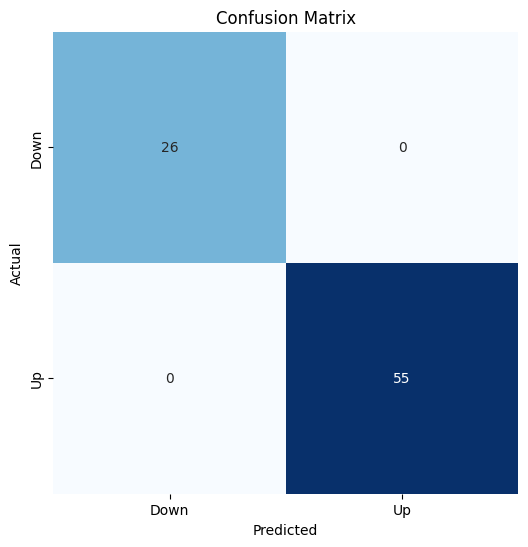

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the Confusion Matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **Test Dataset Generation**

In [18]:
import praw
import pandas as pd

# Initialize PRAW with your Reddit API credentials
reddit = praw.Reddit(client_id='aRUMjsRkJ-mqKAtdvyJqYw',
                     client_secret='Ue2IVDlmbAIn_ZZeitMMigBxIJKMgA',
                     user_agent='StockScrapper by /u/Fuzzy_Tie6180')

# Fetch the top 100 posts from the 'stocks' subreddit
subreddit = reddit.subreddit('stocks')
posts = subreddit.top('day', limit=100)  # Fetch the top posts of the day

# Create a list to store post data
post_data = []
for post in posts:
    post_data.append({
        'title': post.title,
        'score': post.score,
        'url': post.url,
        'created_utc': post.created_utc,
        'comments': post.num_comments
    })

# Convert the list of posts into a DataFrame
df_new = pd.DataFrame(post_data)

# Save the new data to a CSV file for later use
df_new.to_csv('new_reddit_data.csv', index=False)

print("New Reddit data collected and saved.")


<ipython-input-18-2ace9b3bc755>:11: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  posts = subreddit.top('day', limit=100)  # Fetch the top posts of the day
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



New Reddit data collected and saved.


# **Use Random Forest**

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# 1. Feature Extraction: TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Processed Title']).toarray()

# 2. Combine the text data with other numerical features (Sentiment scores)
X_combined = np.hstack([X_text, df[['VADER Sentiment']].values])

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Target Variable: Stock Movement (1 for up, 0 for down)
y = df['Stock Movement']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Random Forest Model with Hyperparameter Tuning
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 10, 20, None],  # Limit tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Features to consider for splitting
}

# Hyperparameter optimization
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)

# 7. Best parameters and model training
print("Best parameters from RandomizedSearchCV:")
print(random_search.best_params_)

model = random_search.best_estimator_

# 8. Predictions and Evaluation
y_pred = model.predict(X_test)

# 9. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. Cross-Validation Scores
cross_val_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Average cross-validated accuracy: {np.mean(cross_val_scores):.4f}")

# 12. Combine Actual and Predicted Values for Display
predicted_df = pd.DataFrame({
    'Actual Stock Movement': y_test,
    'Predicted Stock Movement': y_pred
})

print("\nPredicted Stock Movements:")
print(predicted_df.head())  # Display the first 5 predictions

# 13. Save the Model and Related Objects
joblib.dump(model, 'random_forest_stock_movement_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nModel evaluation completed.")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from RandomizedSearchCV:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3}

Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        55

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validated accuracy: 1.0000

Predicted Stock Movements:
     Actual Stock Movement  Predicted Stock Movement
70                       1                         1
281                      0                         0
283                      0                         0
33                       1                         1
42                       1           


# Predicting Stock Movements On Test Dataset

In [20]:
import pandas as pd
import numpy as np
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the preprocessed new Reddit data
df_new = pd.read_csv('new_reddit_data.csv')

# Perform Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score
def get_vader_sentiment(text):
    if isinstance(text, str):
        sentiment_score = sia.polarity_scores(text)
        return sentiment_score['compound']  # Compound score gives the overall sentiment
    return 0

# Add VADER Sentiment to the DataFrame
df_new['VADER Sentiment'] = df_new['title'].apply(get_vader_sentiment)

# Adjust the sentiment threshold to determine stock movement
df_new['Stock Movement'] = df_new['VADER Sentiment'].apply(lambda x: 1 if x > 0.2 else 0)  # You can adjust threshold as needed

# Convert sentiment to Positive/Negative/Neutral for better understanding (optional)
df_new['Sentiment Category'] = df_new['VADER Sentiment'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Load the saved TfidfVectorizer and StandardScaler
tfidf = joblib.load('tfidf_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')

# Feature Extraction: TF-IDF for text data (use the same vectorizer fitted on the training data)
X_text_new = tfidf.transform(df_new['title']).toarray()  # Use transform instead of fit_transform

# Combine the text data with sentiment scores (VADER Sentiment)
X_combined_new = np.hstack([X_text_new, df_new[['VADER Sentiment']].values])

# Standardize the features using the same scaler as during training
X_scaled_new = scaler.transform(X_combined_new)  # Use transform instead of fit_transform
# Load the trained model (you can replace 'decision_tree_stock_movement_model.pkl' with the model used in training)
model = joblib.load('random_forest_stock_movement_model.pkl')  # Example: Replace with the model you trained

# Make predictions on the new data
y_pred_new = model.predict(X_scaled_new)

# Combine Actual and Predicted Values for Display (if you have actual labels for the new data)
predicted_df_new = pd.DataFrame({
    'Title': df_new['title'],
    'VADER Sentiment': df_new['VADER Sentiment'],
    'Sentiment Category': df_new['Sentiment Category'],
    'Predicted Stock Movement': y_pred_new
})

# Display the first few predictions
print("\nFirst few Predictions with Sentiment Analysis:")
print(predicted_df_new.head())



First few Predictions with Sentiment Analysis:
                                               Title  VADER Sentiment  \
0                        When do you take the money?           0.0000   
1  Playing the TikTok possible ban (META, SNAP, G...          -0.4215   
2                             Portfolio Wrapped 2024           0.0000   
3  What is the investment thesis for the space se...           0.0000   
4                Best strategy for investing in SPY:           0.6369   

  Sentiment Category  Predicted Stock Movement  
0            Neutral                         0  
1           Negative                         0  
2            Neutral                         0  
3            Neutral                         0  
4           Positive                         1  


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
